In [2]:
import os
import re

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# This one is for files that originate from a google drive (scraped data)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = '/content/drive/My Drive/Colab Notebooks/dataset/'
def read_folder(folder):
    examples = []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            files_read = 0  # Counter for the number of files read from each folder
            for fname in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, fname)
                if os.path.isfile(file_path) and file_path.endswith('.txt'):  # Check if it's a file and ends with '.txt'
                    with open(file_path, encoding='utf8') as f:
                        examples.append(f.readline().strip())
    return examples
test_examples = read_folder(folder_path)
print('Number of examples: {}'.format(len(test_examples)))
print('Sample example: {}\n\n'.format(test_examples[0]))
print(test_examples[:10])

Number of examples: 7657
Sample example: Sheffield United manager Chris Wilder has confirmed that Jadon Bogle and Jack Robinson will miss their upcoming #PL match against Burnley due to their injuries.   #SUFC


['Sheffield United manager Chris Wilder has confirmed that Jadon Bogle and Jack Robinson will miss their upcoming #PL match against Burnley due to their injuries.   #SUFC', 'Whatever the outcome on Saturday, what a season it s been.  Let s go one final time on Saturday!   ️ #SUFC #RootsHall', "Aldershot and Gateshead tease each other over 'hoo-ha' for postponed fixture - https://t.co/8C9veElgPk  #afc #avfc #afcb #brentfordfc #bhafc #twitterclarets #cfc #cpfc #efc #ffc #lfc #coyh #ltfc #mancity #mufc #nufc #nffc #twitterblades #sufc #thfc #coys #whufc #coyi #wwfc", 'Prince Abdullah on Instagram. #twitterblades #sufc https://t.co/gkV3YwUrwL', 'Barnsley player gets hit in the head by Portsmouth fan during pitch invasion -  https://t.co/Wloq1qLlcZ  #afc #avfc #afcb #brentfordfc #bh

In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
  '''
  - print auc and accuracy on validation set
  - plot roc
  @params   probs (np.array): array of predicted probabilities with shape (len(y_true), 2)
  @params   y_true (np.array): array of the true values with shape (len(y_true),)
  '''
  preds = probs[:, 1]
  fpr, tpr, threshold = roc_curve(y_true, preds)
  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc:.4f}')
  # accuracy over test set
  y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy*100:.2f}%')

  # plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [7]:
soccer_df = pd.DataFrame({'text': test_examples})
print(soccer_df)

                                                   text
0     Sheffield United manager Chris Wilder has conf...
1     Whatever the outcome on Saturday, what a seaso...
2     Aldershot and Gateshead tease each other over ...
3     Prince Abdullah on Instagram. #twitterblades #...
4     Barnsley player gets hit in the head by Portsm...
...                                                 ...
7652  Although, Wilcox is appointed but Utd's curren...
7653  #mufc Revoke The United Stand's Press Credenti...
7654  Sancho s bonuses for getting into the champion...
7655  #Sirjim is doing a great work at Manchester Un...
7656  EXCLUSIVE: Manchester United have agreed compe...

[7657 rows x 1 columns]


In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '#AFC')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '#name'
    text = re.sub(r'#\w+(\s|$)', ' ', text)


    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove links
    text = re.sub(r'https?://\S+', '', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

sia = SentimentIntensityAnalyzer()
def compute_sentiment(text):
    # Preprocess the text (if needed)
    preprocessed_text = text_preprocessing(text)

    # Compute sentiment score
    scores = sia.polarity_scores(preprocessed_text)

    return scores['compound']

soccer_df['sentiment_score'] = soccer_df['text'].apply(compute_sentiment)

def categorize_sentiment(score):
  if score >= 0:
    return 1
  else:
    return 0

soccer_df['sentiment'] = soccer_df['sentiment_score'].apply(categorize_sentiment)

In [9]:
from sklearn.model_selection import train_test_split

X = soccer_df.text.values
y = soccer_df.sentiment.values
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size = 0.3, random_state = 2020)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size = 0.5, random_state = 2020)

In [11]:
print('X_train: ', X_train[:5])
print('X_val: ', X_val[:5])
print('X_test: ', X_test[:5])
print('y_train: ', y_train[:5])
print('y_val: ', y_val[:5])
print('y_test: ', y_test[:5])

X_train:  ['Enzo Fernandez, Axel Disasi and Raheem Sterling have been taken off Chelsea\'s injury list. And Nkunku is in "partial team training." #CFC #EmiratesFACup'
 "If there's one thing I can be proud of this season, it's that Carrington is still producing quality players        Kobbie   &amp; Alejandro  #MUFC"
 'Pochettino on Palmer:  But it s true we are a coaching staff that we always demand more.  Yes you score, but you need to work. Yes you score, but you need to run when we don t have the ball . But he s doing well.  [standard] #cfc'
 'Charlie Goode has returned to #BrentfordFC midway through his loan spell at Wigan due to  personal reasons  https://t.co/bg1vTvjH3i'
 'Glasner is the first person to arrive at the club s Copers Cope training ground and the last to leave.  Many at the club believe he is one to take them to the next level.   @iamrahmanosman #CPFC https://t.co/8MDUrGPYQc']
X_val:  ["9th tier club win 12-0 at league's worst side after needing 12 goal swing for play

In [12]:
from transformers import DistilBertTokenizer, DistilBertModel

# Change the tokenizer to DistilBERT's tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def preprocessing_for_distilbert(data, max_length=512):
    '''
    Perform required preprocessing steps for pretrained DistilBERT.
    @param   data (np.array): Array of texts to be processed.
    @param   max_length (int): Maximum sequence length.
    @return  input_ids (torch.Tensor): Tensor of token ids to be fed to a model
    @return  attention_masks (torch.Tensor): Tensor of indices specifying which tokens should be attended to by the model
    '''
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # Encode the sentence
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_length,          # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            truncation=True,                # Explicitly truncate to max_length
            return_attention_mask=True      # Return attention mask
        )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
#Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in soccer_df.text.values]

#Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max Length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors


Max Length:  615


In [15]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_distilbert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_distilbert(X_train, max_length=MAX_LEN)
val_inputs, val_masks = preprocessing_for_distilbert(X_val, max_length=MAX_LEN)
test_inputs, test_masks = preprocessing_for_distilbert(X_test, max_length=MAX_LEN)

Original:  Sheffield United manager Chris Wilder has confirmed that Jadon Bogle and Jack Robinson will miss their upcoming #PL match against Burnley due to their injuries.   #SUFC
Token IDs:  [101, 8533, 2142, 3208, 3782, 18463, 2038, 4484, 2008, 14855, 5280, 22132, 2571, 1998, 2990, 6157, 2097, 3335, 2037, 9046, 2674, 2114, 23028, 2349, 2000, 2037, 6441, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train).to(device)
val_labels = torch.tensor(y_val).to(device)
test_labels = torch.tensor(y_test).to(device)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)

In [17]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

class DistilBertClassifier(nn.Module):
    """DistilBERT Model for Classification Tasks.
    """
    def __init__(self, freeze_distilbert=False):
        """
        @param    freeze_distilbert (bool): Set `False` to fine-tune the DistilBERT model
        """
        super(DistilBertClassifier, self).__init__()

        # Instantiate DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Instantiate a feed-forward classifier
        self.classifier = nn.Linear(768, 2)  # Assuming binary classification

        # Freeze the DistilBERT model if specified
        if freeze_distilbert:
            for param in self.distilbert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to DistilBERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to DistilBERT
        outputs = self.distilbert(input_ids=input_ids,
                                  attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 9.85 ms, sys: 1.86 ms, total: 11.7 ms
Wall time: 16 ms


In [18]:
def initialize_distilbert_model(epochs=2):
    # Create the DistilBertClassifier model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    distilbert_classifier = DistilBertClassifier().to(device)

    # Define the optimizer
    optimizer = AdamW(distilbert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                     )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

    return distilbert_classifier, optimizer, scheduler


In [19]:
# Import necessary libraries
import random
import time
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Specify loss function
loss_fn = torch.nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def initialize_distilbert_model(epochs=2):
    # Create the DistilBertClassifier model
    distilbert_classifier = DistilBertClassifier()

    # Define the optimizer
    optimizer = AdamW(distilbert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                     )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

    return distilbert_classifier, optimizer, scheduler

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the DistilBertClassifier model."""

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        # =======================================
        #               Training
        # =======================================

        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1

            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

            # Free up GPU memory at the end of each batch
            del batch
            torch.cuda.empty_cache()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)

        # =======================================
        #               Evaluation
        # =======================================

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set."""

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [20]:
# Set seed for reproducibility
set_seed(42)

# Initialize model, optimizer, and scheduler
distilbert_classifier, optimizer, scheduler = initialize_distilbert_model(epochs=2)

# Train the model
train(distilbert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.487986   |     -      |     -     |  453.77  
   1    |   40    |   0.359545   |     -      |     -     |  424.90  
   1    |   60    |   0.330493   |     -      |     -     |  417.79  
   1    |   80    |   0.270221   |     -      |     -     |  418.76  
   1    |   100   |   0.287637   |     -      |     -     |  416.60  
   1    |   120   |   0.247758   |     -      |     -     |  416.28  
   1    |   140   |   0.289239   |     -      |     -     |  420.48  
   1    |   160   |   0.260651   |     -      |     -     |  417.36  
   1    |   167   |   0.233709   |     -      |     -     |  135.75  
----------------------------------------------------------------------
   1    |    -    |   0.314253   |  0.249494  |   90.10   |  3767.45 
---------------------------------------------------------------------

In [21]:
import torch.nn.functional as F

def distilbert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to CPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        all_logits.append(logits)

        # Free up GPU memory
        del b_input_ids
        del b_attn_mask
        torch.cuda.empty_cache()

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs


In [22]:
probs = distilbert_predict(distilbert_classifier, test_dataloader)

AUC: 0.4927
Accuracy: 64.06%


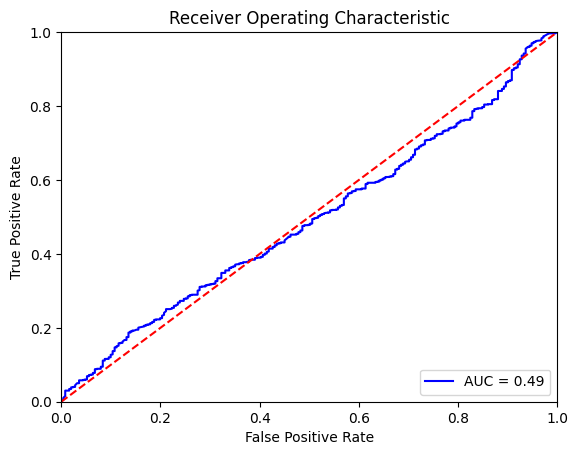

In [23]:
evaluate_roc(probs, y_test)

In [26]:
import numpy as np
from sklearn.metrics import f1_score

# Threshold the probabilities to get binary predictions
y_pred = np.where(probs[:, 1] >= 0.5, 1, 0)

# Compute the F1-score
f1 = f1_score(y_test, y_pred)

print("F1-score:", f1)


F1-score: 0.7704280155642023
